# Введение в обработку естественного языка
# Урок 4. Тематическое моделирование. EM-алгоритм

__Задача тематическое моделирование__

Продолжаем исследование датасета с твитами

Скачиваем датасет (источник - http://study.mokoron.com/):
- положительные - https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0,
- отрицательные - https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv.

Или можно через ноутбук:
- !wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
- !wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук parse_rospotrebnadzor.ipynb
устанавливаем количество скачанных страниц больше не 50-сят, хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда.

Что надо сделать:
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

Сдайте задание до: 9 июня, 22:00 +05

Выполнил ___Соковнин ИЛ___

# 
# <font color='darkblue'>Задания:</font>

### Задача 1.

Скачивание и подготовка данных из Роспотребнадзора https://zpp.rospotrebnadzor.ru/Forum/Appeals см. файл __parse_rospotrebnadzor_hw.ipynb__. 

Скачано  500 страниц.  Для анализа взяты только вопросы.

In [1]:
import pandas as pd

In [2]:
columns = ['text'] 
question_df = pd.read_csv("./data/rpn_question.csv", names = columns)
question_df.head()

,text
0,24 мая 2022 года получил в подарок сертификат ...
1,Добрый день! помогите пожалуйста разобраться в...
2,Добрый день.\r\nКупила в магазине техники элек...
3,Добрый день.\r\nКупила в магазине техники элек...
4,Добрый день!\r\nПрошу вас разъяснить следующий...


# 
### Задача 2.

провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать

### Предобработка

In [ ]:
!pip install corus

In [3]:
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
# from pymystem3 import Mystem

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# !pip install pymorphy2

In [6]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [7]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [8]:
question_df.text.iloc[1]

'Добрый день! помогите пожалуйста разобраться в ситуации. в приложении Вайлдберриз я заказала игрушку для сына 16 мая этого года. срок доставки стоял 19-20 мая. однако в этот срок игрушку не доставили, более того, пишут каждый раз что товар задерживается и ставят новые сроки. что мне делать? могу я как-то уже отказаться от неё?'

In [9]:
print(preprocess(question_df.text.iloc[1]))

['добрый', 'день', 'помочь', 'пожалуйста', 'разобраться', 'ситуация', 'приложение', 'вайлдберриз', 'заказать', 'игрушка', 'сын', 'май', 'это', 'год', 'срок', 'доставка', 'стоять', 'май', 'однако', 'срок', 'игрушка', 'доставить', 'писать', 'каждый', 'товар', 'задерживаться', 'ставить', 'новый', 'срок', 'делать', 'мочь', 'отказаться']


In [10]:
preprocessed_text = list(tqdm(map(preprocess, question_df['text']), total=len(question_df)))

In [11]:
question_df['text'] = preprocessed_text
question_df.sample(3)

,text
1885,"[здравствуйте, оплатить, товар, алиэкспресс, с..."
1060,"[компания, представиться, юридический, организ..."
1149,"[гражданин, вакцинировать, пфайзер, молдавия, ..."


## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [21]:
!pip install -U gensim


     ---------------------------------------- 24.0/24.0 MB 4.5 MB/s eta 0:00:00
     -------------------------------------- 983.8/983.8 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.23
    Uninstalling Cython-0.29.23:



ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'c:\\programdata\\anaconda3\\lib\\site-packages\\__pycache__\\cython.cpython-38.pyc'
Consider using the `--user` option or check the permissions.



In [12]:
from gensim.models import *
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [13]:
dictionary = corpora.Dictionary(question_df['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lenta.dict')

Векторизуем документы:

In [14]:
corpus = [dictionary.doc2bow(text) for text in question_df['text']]
corpora.MmCorpus.serialize('lenta.model', corpus) 

Теперь можем обучать модель:

In [15]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

Wall time: 2.64 s


Посмотрим на получившиеся темы:

In [16]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(5,
  '0.170*"делать" + 0.102*"упаковка" + 0.068*"начало" + 0.049*"весь" + 0.043*"понимать" + 0.042*"оказаться" + 0.042*"домой" + 0.039*"человек" + 0.037*"это" + 0.031*"всё"'),
 (0,
  '0.046*"торговый" + 0.042*"сертификат" + 0.041*"выдать" + 0.031*"кредит" + 0.028*"московский" + 0.027*"дать" + 0.026*"кроме" + 0.026*"нарушить" + 0.025*"продукция" + 0.024*"отдел"'),
 (14,
  '0.032*"день" + 0.028*"сказать" + 0.027*"телефон" + 0.026*"это" + 0.023*"мочь" + 0.020*"номер" + 0.018*"всё" + 0.014*"центр" + 0.014*"сделать" + 0.013*"здравствуйте"'),
 (9,
  '0.089*"компания" + 0.064*"медицинский" + 0.055*"ооо" + 0.047*"отказываться" + 0.046*"петербург" + 0.045*"санкт" + 0.043*"решение" + 0.037*"произвести" + 0.033*"вопрос" + 0.030*"переписка"'),
 (2,
  '0.134*"товар" + 0.131*"магазин" + 0.040*"продавец" + 0.028*"купить" + 0.027*"покупка" + 0.024*"доставка" + 0.024*"вернуть" + 0.022*"день" + 0.021*"приобрести" + 0.019*"возврат"'),
 (4,
  '0.113*"заказ" + 0.086*"возврат" + 0.068*"средство" + 0.066*"

# 
## Задача 3.
<font color='darkblue'>сделать визуализацию кластеров тематик</font>

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки pyLDAvis. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [32]:
!pip install pyLDAvis

  Using cached pyLDAvis-3.3.1-py2.py3-none-any.whl
  Using cached sklearn-0.0-py2.py3-none-any.whl


In [17]:
import pyLDAvis

In [20]:
# import pyLDAvis.gensim as gensimvis
import pyLDAvis.gensim_models as gensimvis

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Wall time: 5.24 s


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [22]:
print(lda.log_perplexity(corpus))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-11.691879024670575


In [23]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Персплексия:  8.361376773967142e-06


In [25]:
coherence_model_lda = CoherenceModel(model=lda, texts=question_df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Средняя когерентность:  0.3475513418552212


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


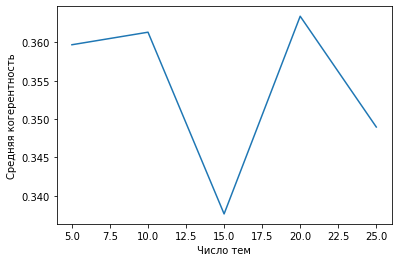

In [28]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=question_df['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [29]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=15, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [30]:
lda_15 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2)
vis_data = gensimvis.prepare(lda_15, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Видно, что для качественной тематизации неоходима дополнительна предобработка тексто.<br>
В частности включить в стоп лист, слова общего значения, которые не определяют тематики.<br>
Такие как: это, дата, год, также, ооо, дать и т. д.

# 
## Задача 4.
<font color='darkblue'>проинтерпритировать получившиеся тематики</font>

## 
Проинтерпритируем несколько тематик

___Тематика 1. Смысл достаточно чёткий. Можно назвать тематику "Правовая защита потребителя"___

Тематика_1 = [
право,
договор,
код,
документ,
рубль,
дать,
потребитель,
закон,
также,
который,
просить,
информация,
нарушение,
связь,
действие,
компания,
ответ,
отказ,
это,
предоставить,
год,
требовать,
дата,
защита,
ковид,
сумма,
ооо,
медицинский,
направить,
обратиться
]

___Тематика 2. Смысл достаточно чёткий. Можно назвать тематику "Проблемы связанные с получением заказа".___

Тематика_2 = [
товар,
заказ,
деньга,
сайт,
интернет,
вернуть,
день,
магазин,
возврат,
доставка,
продавец,
оплатить,
получить,
руб,
оплата,
отменить,
обращение,
https,
почта,
оформить,
поддержка,
указать,
банк,
заказать,
сообщение,
приобрести,
пункт,
ozon,
отправить,
кабинет
]

___Тематика 3 - достаточно сумбурная. Похоже на общий вопрос о помощи без чёткой формулировки проблемы.<br>
Общий смысл - "Куда обратиться и что делать для решения проблемы".___

Тематика 3 = [это,
сказать,
всё,
день,
мочь,
ещё,
ноябрь,
делать,
свой,
написать,
прийти,
ситуация,
дать,
сегодня,
который,
время,
купить,
хотя,
обратиться,
попросить,
первый,
позвонить,
решить,
сделать,
карта,
добрый,
здравствуйте,
ответить,
работать,
упаковка]

___Тематика 4. Смысл чёткий. Можно назвать тематику "Гарантийный ремонт и сервисное обслуживание".___

Тематика 4 = [
магазин,
товар,
цена,
центр,
купить,
проверка,
адрес,
продажа,
покупка,
ремонт,
продавец,
данный,
чек,
просить,
сервисный,
образ,
производитель,
этаж,
паспорт,
вид,
здравствуйте,
это,
срок,
кредит,
обнаружить,
продавать,
качество,
вход,
наличие,
жалоба
]

___Тематика 5. Смысл чёткий. Можно назвать тематику "Сервисное обслуживание клиентов".___

Тематика 5 = [
принять,
выдача,
адрес,
заявка,
просить,
мера,
покупатель,
горячий,
номер,
сотрудник,
итог,
линия,
это,
водитель,
работа,
продукт,
человек,
звонить,
звонок,
дверь,
минута,
стать,
автобус,
предлагать,
объяснить,
отделение,
который,
вызвать,
место,
проблема
]